This script is meant to contain a bunch of timeseries diagrams that show how certain variables are changing over time. At the moment it is very messy due to some... experimentation with the best way to protry these time series given the disperse sampling time of the Wade and CTD data. Hopefully, we can acquire some moore data that will allow for the formation of more detailed timeseries. This notebook will allow for multiple years to e viewed easily. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean
import json
import f90nml
import xarray as xr
import datetime as dt
from collections import OrderedDict

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [3]:
years=range(2007,2020)
modelversion='nowcast-green.201905'
PATH= '/results2/SalishSea/nowcast-green.201905/'
datadir='/ocean/eolson/MEOPAR/obs/WADE/ptools_data/ecology'

In [4]:
display(Markdown('''## Years: '''+ str(years)))

## Years: range(2007, 2020)

In [5]:
display(Markdown('''### Model output: '''+ PATH))

### Model output: /results2/SalishSea/nowcast-green.201905/

In [6]:
##### Loading in pickle file data
saveloc='/ocean/kflanaga/MEOPAR/savedData'
dictBot=dict()

for Y in years:
    with open(os.path.join(saveloc,f'data_WADE_{modelversion}_{Y}.pkl'),'rb') as hh:
        dictBot[Y]=pickle.load(hh)
        
data=pd.concat(dictBot.values(), ignore_index=True)

In [7]:
cm1=cmocean.cm.thermal
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/bathymetry_201702.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])

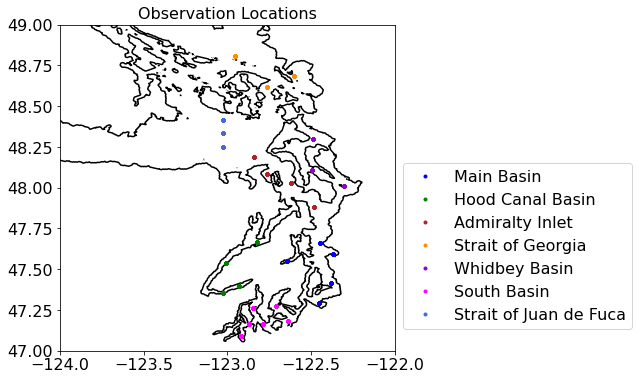

In [8]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('blue','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue')
datreg=dict()
for ind, iregion in enumerate(data.Basin.unique()):
    datreg[iregion] = data.loc[data.Basin==iregion]
    ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
            color = colors[ind], label=iregion)
ax.set_ylim(47, 49)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-124, -122);
ax.set_title('Observation Locations');

iz=(data.Z<15)

# When working with multiple years, a for loop is necessary to split things up by months. 
JFMd=dict()
Aprd=dict()
MJJAd=dict()
SONDd=dict()
for i in years:
    JFMd[i]=data.loc[iz&(data.dtUTC<=dt.datetime(i,4,1)),:]
    Aprd[i]=data.loc[iz&(data.dtUTC<=dt.datetime(i,5,1))&(data.dtUTC>dt.datetime(i,4,1)),:]
    MJJAd[i]=data.loc[iz&(data.dtUTC<=dt.datetime(i,9,1))&(data.dtUTC>dt.datetime(i,5,1)),:]
    SONDd[i]=data.loc[iz&(data.dtUTC>dt.datetime(i,9,1)),:]
JFM=pd.concat(JFMd.values(), ignore_index=True)
Apr=pd.concat(Aprd.values(), ignore_index=True)
MJJA=pd.concat(MJJAd.values(), ignore_index=True)
SOND=pd.concat(SONDd.values(), ignore_index=True)

In [9]:
#creating new dictionaries that make it easy to call on specific years.
datstat=dict()
for ind, istation in enumerate(data.Station.unique()):
    datstat[istation]=data.loc[data.Station == istation]
    
datyear=dict()
for ind, iyear in enumerate(data.dtUTC.dt.year.unique()):
    datyear[iyear] = data.loc[data.dtUTC.dt.year==iyear]
    
datyearreg=dict()
for iyear in datyear:
    datyearreg[iyear]=dict()
    for iregion in datyear[iyear].Basin.unique():
        datyearreg[iyear][iregion]=datyear[iyear].loc[datyear[iyear].Basin==iregion]

In [10]:
def byDepth(ax,obsvar,modvar,lims,byyear = False,year = 'NA'):
    if byyear == False:
        ps=et.varvarPlot(ax,data,obsvar,modvar,'Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
        l=ax.legend(handles=ps)
    elif byyear == True:
        ps=et.varvarPlot(ax,datyear[year],obsvar,modvar,'Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
        l=ax.legend(handles=ps)
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps,l

def byRegion(ax,obsvar,modvar,lims,year):
    ps=[]
    for ind, iregion in enumerate(data[data.dtUTC.dt.year==year].Basin.unique()):
        ax.plot(datyearreg[year][iregion]['Lon'], datyearreg[year][iregion]['Lat'],'.',
                color = colors[ind], label=iregion)
        ps0=et.varvarPlot(ax,datyearreg[year][iregion],obsvar,modvar,
                        cols=(colors[ind],),lname=iregion)
        ps.append(ps0)
    l=ax.legend(handles=[ip[0][0] for ip in ps])
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps,l

def byStation(ax,obsvar,modvar,lims,region):
    ps=[]
    for ind, istation in enumerate(data[data['Basin'] == region].Station.unique()):
        ax.plot(datstat[istation]['Lon'], datstat[istation]['Lat'],'.',
                    color = colors[ind], label=istation)
        ps0=et.varvarPlot(ax,datstat[istation],obsvar,modvar,
                            cols=(colors[ind],),lname=istation)
        ps.append(ps0)
    l=ax.legend(handles=[ip[0][0] for ip in ps])
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps,l

def bySeason(ax,obsvar,modvar,lims):
    for axi in ax:
        axi.plot(lims,lims,'k-')
        axi.set_xlim(lims)
        axi.set_ylim(lims)
        axi.set_aspect(1)
        axi.set_xlabel('Obs')
        axi.set_ylabel('Model')
    ps=et.varvarPlot(ax[0],JFM,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[0].set_title('Jan-Mar')
    ps=et.varvarPlot(ax[1],Apr,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[1].set_title('Apr')
    ps=et.varvarPlot(ax[2],MJJA,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[2].set_title('May-Aug')
    ps=et.varvarPlot(ax[3],SOND,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[3].set_title('Sep-Dec')
    return 

def ErrErr(fig,ax,obsvar1,modvar1,obsvar2,modvar2,lims1,lims2):
    m=ax.scatter(data[modvar1]-data[obsvar1],data[modvar2]-data[obsvar2],c=data['Z'],s=1,cmap='gnuplot')
    cb=fig.colorbar(m,ax=ax,label='Depth (m)')
    ax.set_xlim(lims1)
    ax.set_ylim(lims2)
    ax.set_aspect((lims1[1]-lims1[0])/(lims2[1]-lims2[0]))
    return m,cb

In [11]:
def multi_timerror_graph(figsize,years,obsvar,modvar):
    fig,ax=plt.subplots(len(years),1,figsize=figsize)
    for d,Y in zip(range(len(years)),years):
            m=ax[d].scatter(datyear[Y]['dtUTC'],datyear[Y][modvar]-datyear[Y][obsvar],s=8,cmap='gnuplot') 
            ax[d].set_xlabel(f'Date',fontsize=20)
            ax[d].set_ylabel(f'{obsvar} Error ($\mu$M)',fontsize=20)
            ax[d].set_title(str(Y), fontsize=22)
            yearsFmt = mdates.DateFormatter('%d %b')
            ax[d].xaxis.set_major_formatter(yearsFmt)
    plt.tight_layout()

# this function is in the middle of being updated.
def multi_meanerr_graph(df,figsize,obsvar,modvar):
    for d,Y in zip(range(down),years):
            meanerr=datyear[Y].groupby(by='dtUTC').mean()
            m=ax[d].plot(datyear[Y]['dtUTC'].unique(),meanerr[modvar]-meanerr[obsvar],'c-') 
            ax[d].set_xlabel(f'Date',fontsize=20)
            ax[d].set_ylabel(f'{obsvar} Error ($\mu$M)',fontsize=20)
            ax[d].set_title(str(Y), fontsize=22)
            yearsFmt = mdates.DateFormatter('%d %b')
            ax[d].xaxis.set_major_formatter(yearsFmt)
    plt.tight_layout()

# Creating an automatic time series plot maker.

In [41]:
#Note that once you put this into evaltools you must remove any calls to eval_tools.
#Perhaps I could use try except functions to make it so that I could look at individual ranges?
def tsertser_graph(ax,df,obsvar,modvar,start_date,end_date,sepvar='',sepvals=([]),lname='',sepunits='',
                  ocols=('blue','darkviolet','teal','green','deepskyblue'),
                  mcols=('fuchsia','firebrick','orange','darkgoldenrod','maroon'),labels=''):
    """ Creates timeseries by adding scatter plot to axes ax with df['dtUTC'] on x-axis, 
        df[obsvar] and df[modvar] on y axis, and colors taken from a listas determined from 
        df[sepvar] and a list of bin edges, sepvals
    """
    if len(lname)==0:
        lname=sepvar
    ps=list()
    if len(sepvals)==0:
        obs0=et._deframe(df.loc[(df['dtUTC'] >= start_date)&(df['dtUTC']<= end_date),[obsvar]])
        mod0=et._deframe(df.loc[(df['dtUTC'] >= start_date)&(df['dtUTC']<= end_date),[modvar]])
        time0=et._deframe(df.loc[(df['dtUTC'] >= start_date)&(df['dtUTC']<= end_date),['dtUTC']])
        p0,=ax.plot(time0,obs0,'.',color=ocols[0],label=f'Observed {lname}')
        ps.append(p0)
        p0,=ax.plot(time0,mod0,'.',color=mcols[0],label=f'Modeled {lname}')
        ps.append(p0)
    else:
        obs0=et._deframe(df.loc[(df[obsvar]==df[obsvar])&(df[modvar]==df[modvar])&(df[sepvar]==df[sepvar])&(df['dtUTC'] >= start_date)&(df['dtUTC']<= end_date),[obsvar]])
        mod0=et._deframe(df.loc[(df[obsvar]==df[obsvar])&(df[modvar]==df[modvar])&(df[sepvar]==df[sepvar])&(df['dtUTC'] >= start_date)&(df['dtUTC']<= end_date),[modvar]])
        time0=et._deframe(df.loc[(df[obsvar]==df[obsvar])&(df[modvar]==df[modvar])&(df[sepvar]==df[sepvar])&(df['dtUTC'] >= start_date)&(df['dtUTC']<= end_date),['dtUTC']])
        sep0=et._deframe(df.loc[(df[obsvar]==df[obsvar])&(df[modvar]==df[modvar])&(df[sepvar]==df[sepvar])&(df['dtUTC'] >= start_date)&(df['dtUTC']<= end_date),[sepvar]])
        sepvals=np.sort(sepvals)
                # less than min case:
        ii=0
        iii=sep0<sepvals[ii]
        if np.sum(iii)>0:
            #ll=u'{} < {} {}'.format(lname,sepvals[ii],sepunits).strip()
            if len(labels)>0:
                ll=labels[0]
            else:
                ll=u'{} $<$ {} {}'.format(lname,sepvals[ii],sepunits).strip()
            p0,=ax.plot(time0[iii],obs0[iii],'.',color=ocols[ii],label=f'Observed {ll}')
            ps.append(p0)
            p0,=ax.plot(time0[iii],mod0[iii],'.',color=mcols[ii],label=f'Modeled {ll}')
            ps.append(p0)
        # between min and max:
        for ii in range(1,len(sepvals)):
            iii=np.logical_and(sep0<sepvals[ii],sep0>=sepvals[ii-1])
            if np.sum(iii)>0:
                #ll=u'{} {} \u2264 {} < {} {}'.format(sepvals[ii-1],sepunits,lname,sepvals[ii],sepunits).strip()
                if len(labels)>0:
                    ll=labels[ii]
                else:
                    ll=u'{} {} $\leq$ {} $<$ {} {}'.format(sepvals[ii-1],sepunits,lname,sepvals[ii],sepunits).strip()
            p0,=ax.plot(time0[iii],obs0[iii],'.',color=ocols[ii],label=f'Observed {ll}')
            ps.append(p0)
            p0,=ax.plot(time0[iii],mod0[iii],'.',color=mcols[ii],label=f'Modeled {ll}')
            ps.append(p0)
        # greater than max:
        iii=sep0>=sepvals[ii]
        if np.sum(iii)>0:
            #ll=u'{} \u2265 {} {}'.format(lname,sepvals[ii],sepunits).strip()
            if len(labels)>0:
                ll=labels[ii+1]
            else:
                ll=u'{} $\geq$ {} {}'.format(lname,sepvals[ii],sepunits).strip()
            p0,=ax.plot(time0[iii],obs0[iii],'.',color=ocols[ii+1],label=f'Observed {ll}')
            ps.append(p0)
            p0,=ax.plot(time0[iii],mod0[iii],'.',color=mcols[ii+1],label=f'Modeled {ll}')
            ps.append(p0)
    yearsFmt = mdates.DateFormatter('%d %b %y')
    ax.xaxis.set_major_formatter(yearsFmt)
    return ps

[<matplotlib.lines.Line2D object at 0x7fe8b0bdc550>, <matplotlib.lines.Line2D object at 0x7fe8b0a69a90>, <matplotlib.lines.Line2D object at 0x7fe8b0a69d90>, <matplotlib.lines.Line2D object at 0x7fe8b0bc19d0>, <matplotlib.lines.Line2D object at 0x7fe8b0bc1ca0>, <matplotlib.lines.Line2D object at 0x7fe8b0bc1970>]


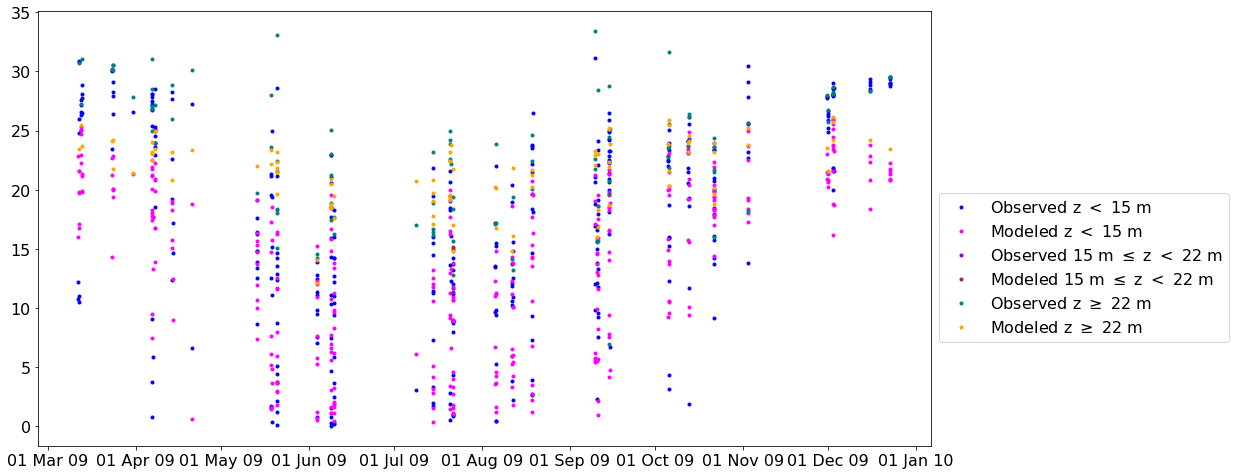

In [42]:
obsvar='NO23'
modvar='mod_nitrate'
start_date=dt.datetime(2009,1,1)
end_date=dt.datetime(2009,12,31)
fig,ax=plt.subplots(1,1,figsize=(16,8))
ps=tsertser_graph(ax,data,obsvar,modvar,start_date,end_date,'Z',(15,22),'z','m')
print(ps)
#for i in ps:
ax.legend(handles=ps,bbox_to_anchor=[1,.6,0,0])

In [43]:
def multi_timese_graph(df,years,obsvar,modvar,figsize):
    fig,ax=plt.subplots(len(years),1,figsize=figsize)
    for d,Y in zip(range(len(years)),years):
            ps=tsertser_graph(ax[d],df,obsvar,modvar,dt.datetime(Y,1,1),dt.datetime(Y,12,31),'Z',(15,22),'z','m')
            ax[d].legend(handles=ps,bbox_to_anchor=[1,.6,0,0])
            ax[d].set_xlabel(f'Date',fontsize=20)
            ax[d].set_ylabel(f'{obsvar} ($\mu$M)',fontsize=20)
            ax[d].set_title(str(Y), fontsize=22)
            plt.setp(ax[d].get_xticklabels(), rotation=30, horizontalalignment='right')
            plt.tight_layout()

## Observed nitrate and model nitrate over time

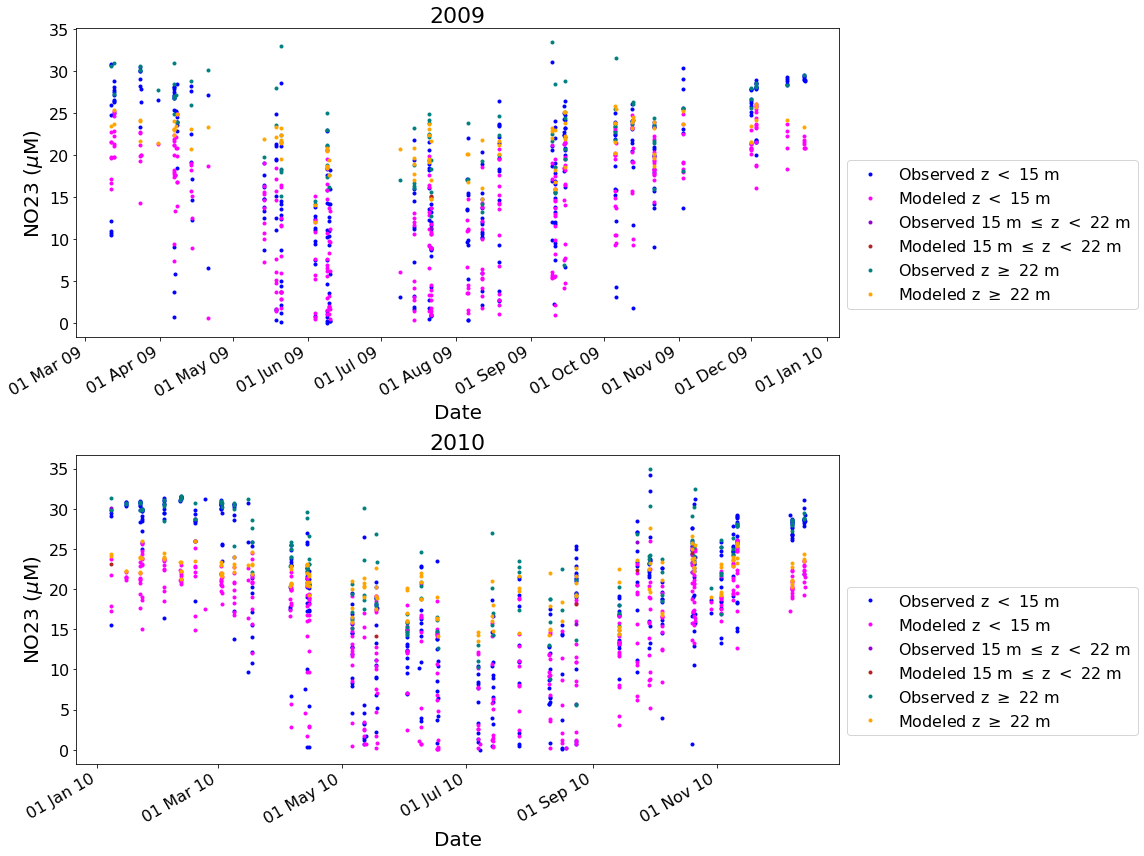

In [44]:
obsvar='NO23'
modvar='mod_nitrate'

multi_timese_graph(data,[2009,2010],obsvar,modvar,(16,12))

## Observed silicate and model silicate over time

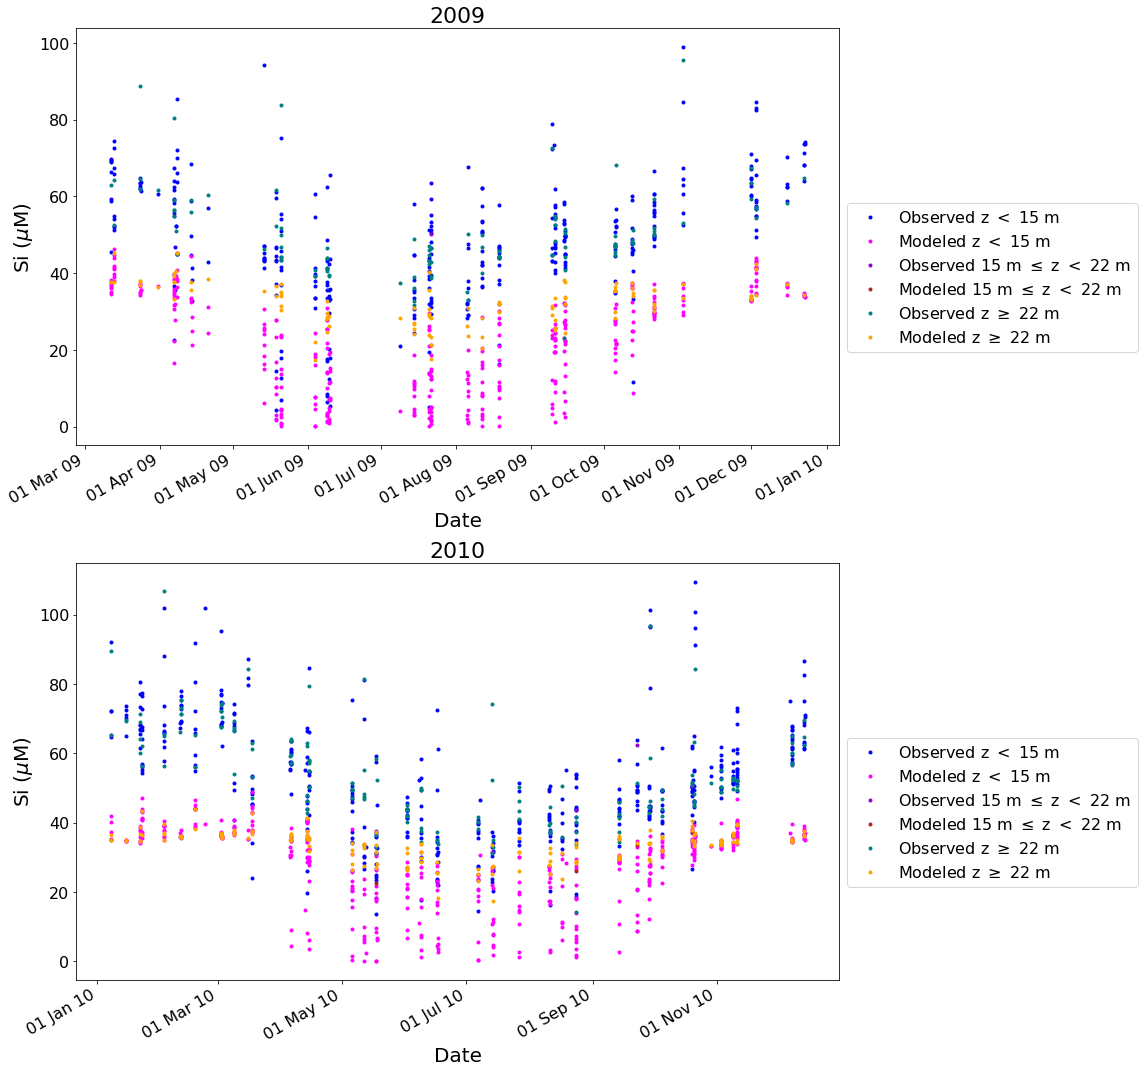

In [45]:
obsvar='Si'
modvar='mod_silicon'

multi_timese_graph(data,[2009,2010],obsvar,modvar,(16,15))

## Observed Ammonia and model Ammonia over time

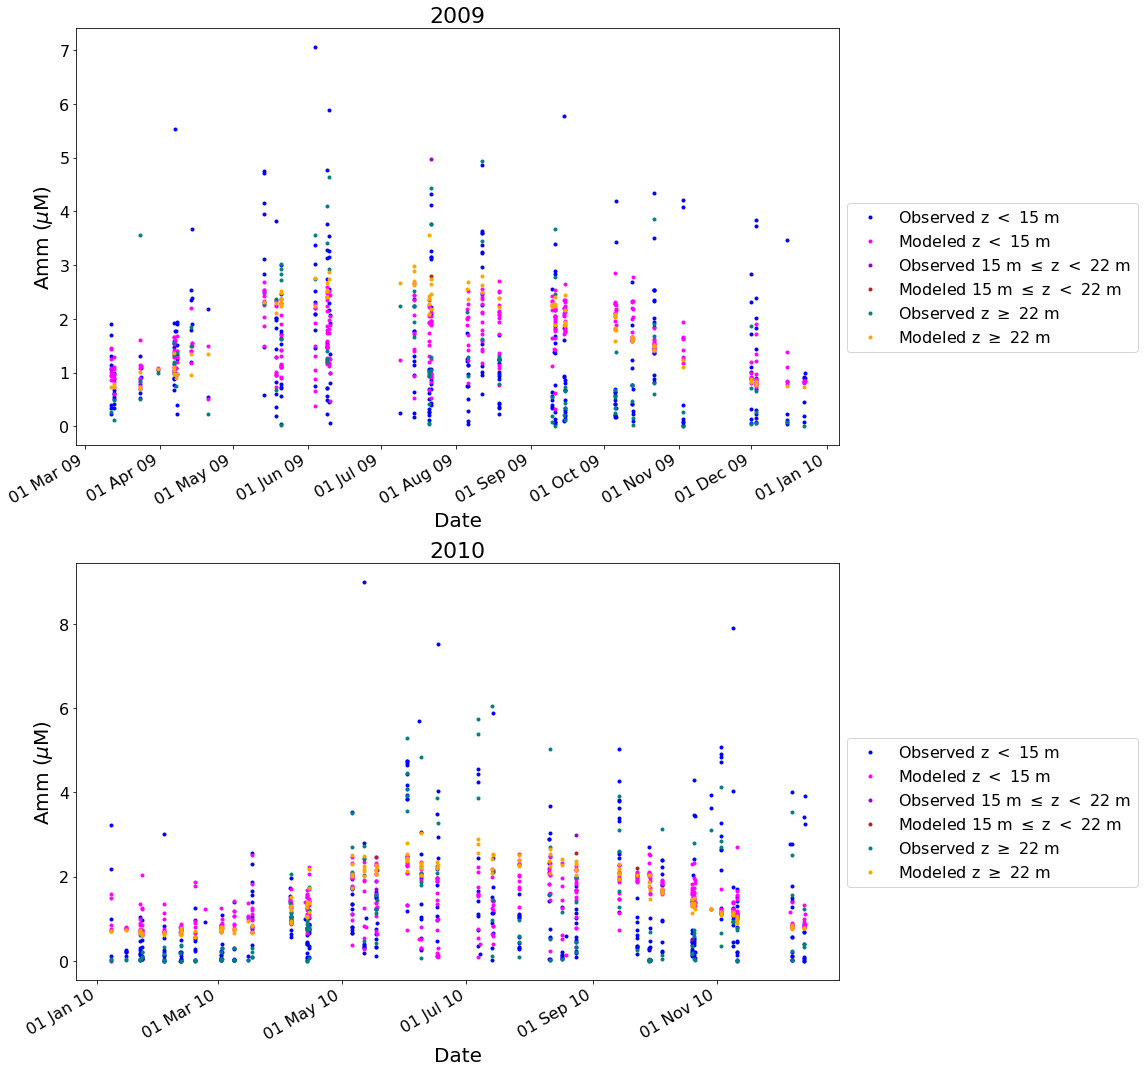

In [46]:
obsvar='Amm'
modvar='mod_ammonium'

multi_timese_graph(data,[2009,2010],obsvar,modvar,(16,15))

# Error vs time of year

## Nitrate

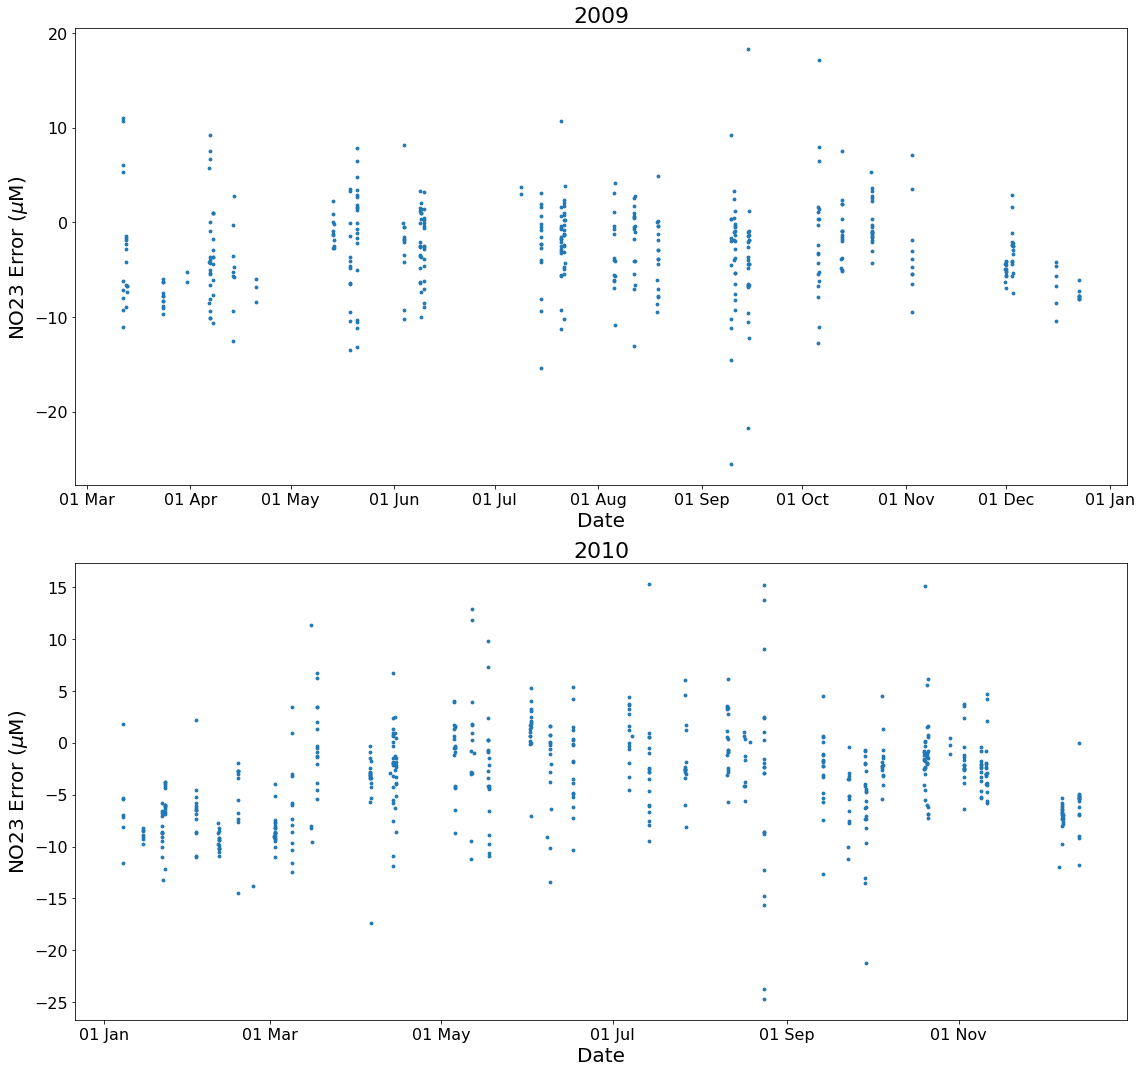

In [47]:
obsvar='NO23'
modvar='mod_nitrate'

multi_timerror_graph((16,15),[2009,2010],obsvar,modvar)

## Silicon

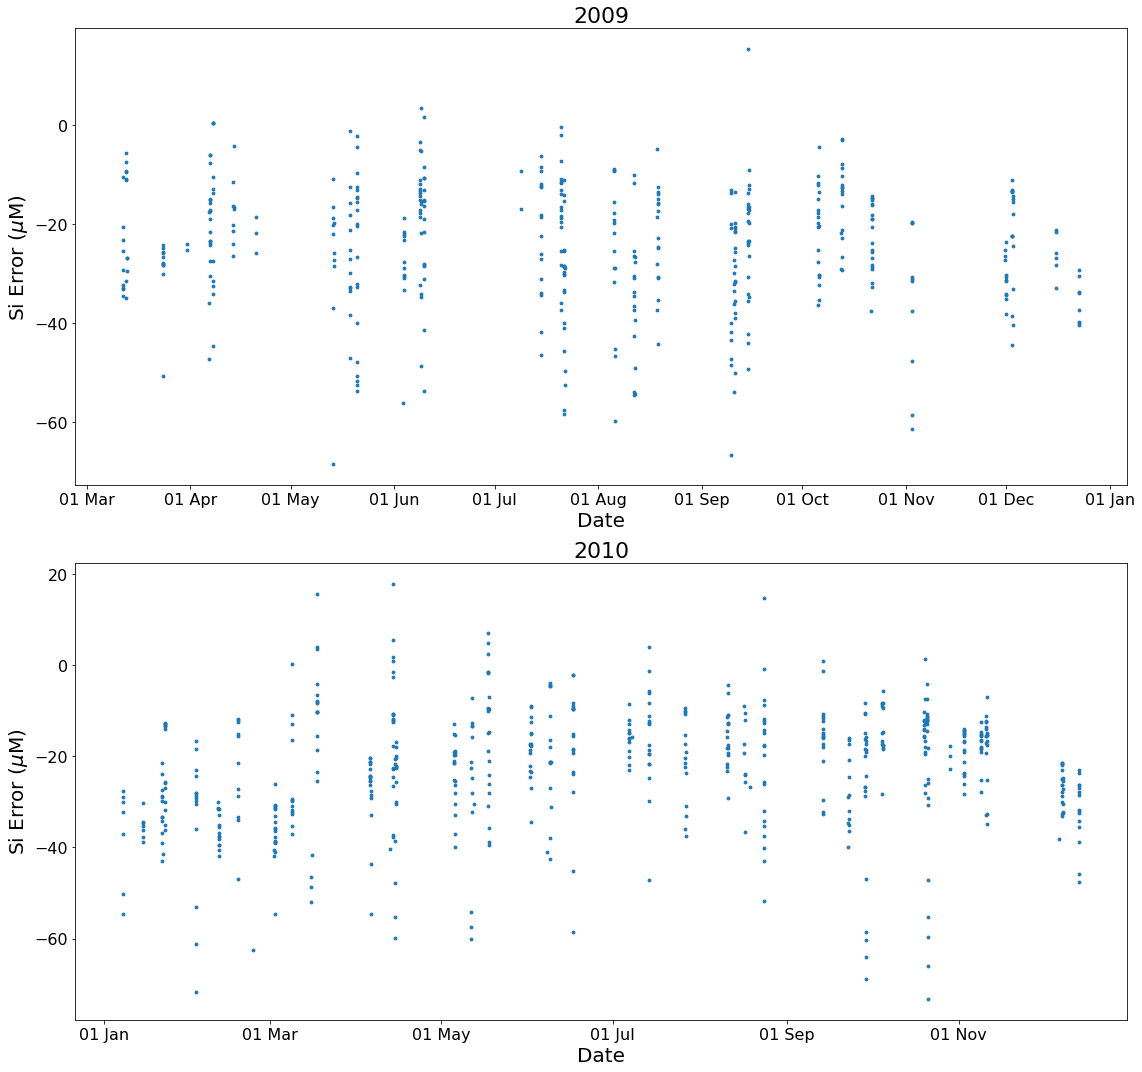

In [48]:
obsvar='Si'
modvar='mod_silicon'

multi_timerror_graph((16,15),[2009,2010],obsvar,modvar)

## Ammonium

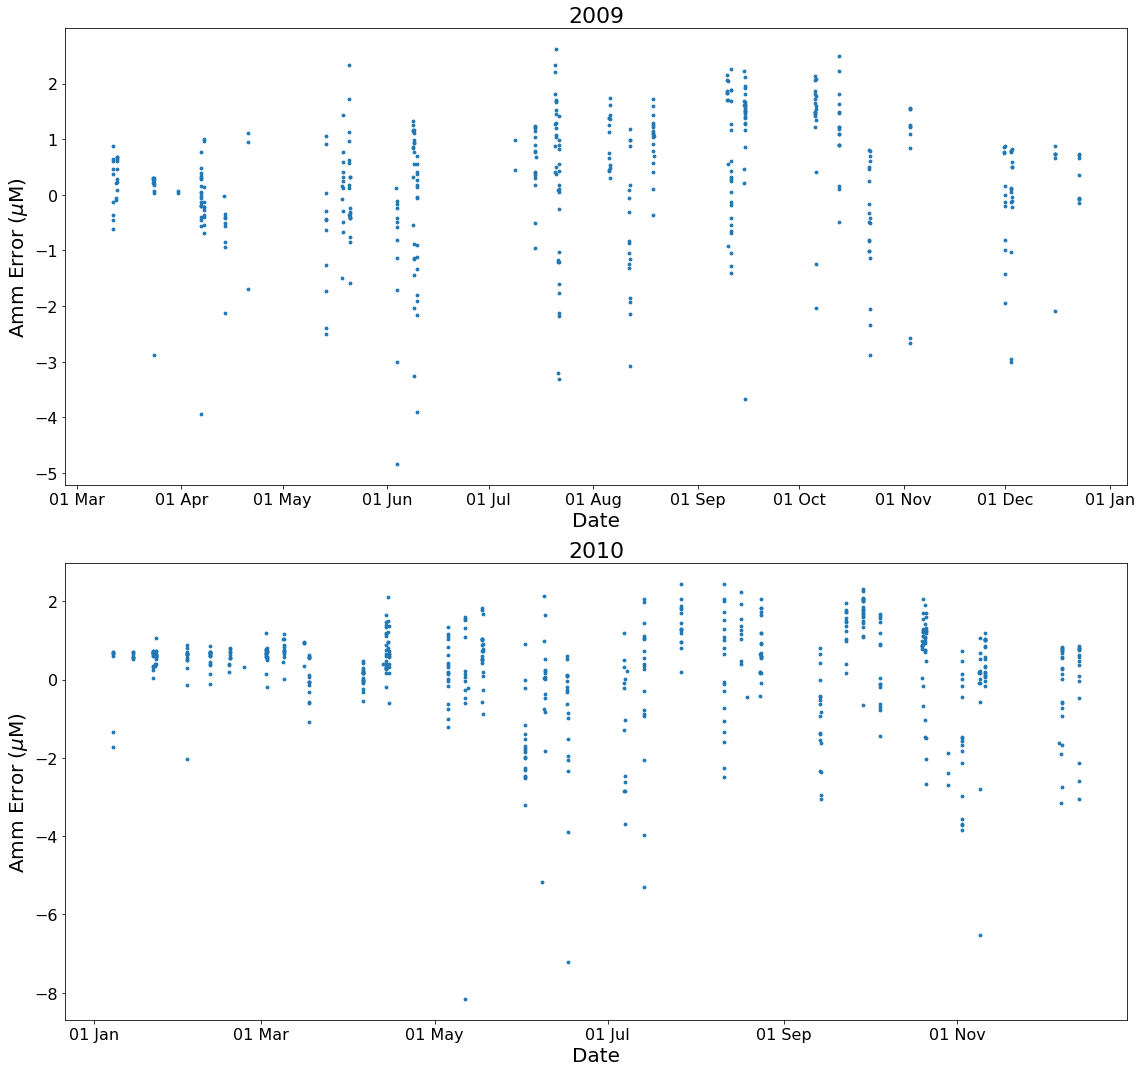

In [49]:
obsvar='Amm'
modvar='mod_ammonium'

multi_timerror_graph((16,15),[2009,2010],obsvar,modvar)

# All years condensed timeseries.

In [98]:
def all_years(obsvar,modvar):
    start_date=dt.datetime(2007,1,1)
    end_date=dt.datetime(2019,12,31)
    fig,ax=plt.subplots(1,1,figsize=(19,8))
    ps=tsertser_graph(ax,data,obsvar,modvar,start_date,end_date)
    ax.legend(handles=ps)
    ax.set_ylabel(f'{obsvar} ($\mu$M)')
    ax.set_xlabel('Date')
    ax.set_title(f'Timeseries of modeled and observed {obsvar} for years 2007-2019')
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    M = 15
    xticks = mpl.ticker.MaxNLocator(M)
    ax.xaxis.set_major_locator(xticks)

## Nitrate

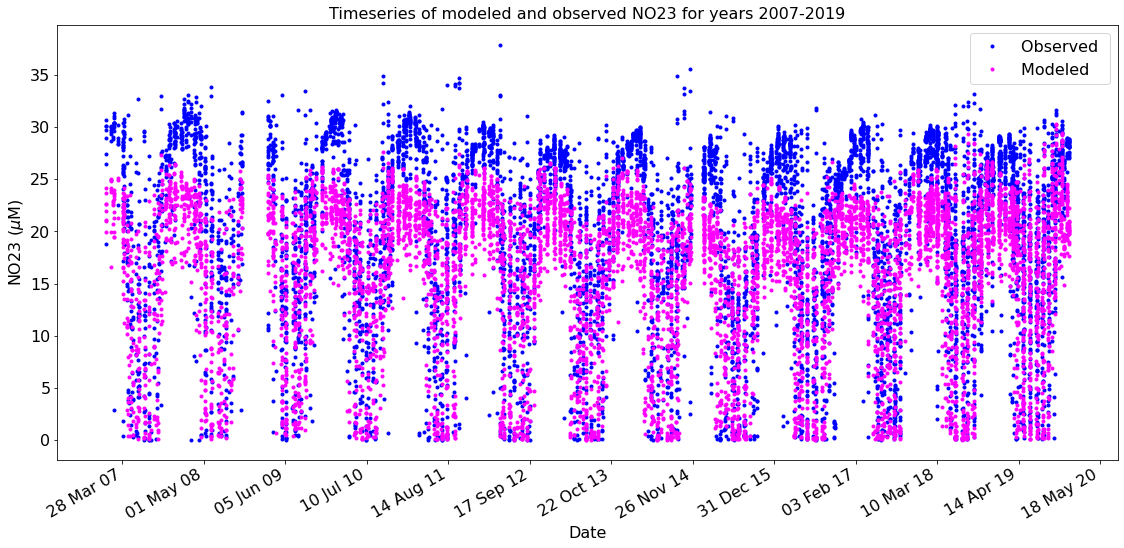

In [99]:
obsvar='NO23'
modvar='mod_nitrate'
all_years(obsvar,modvar)

## Silicon

(0.0, 120.0)

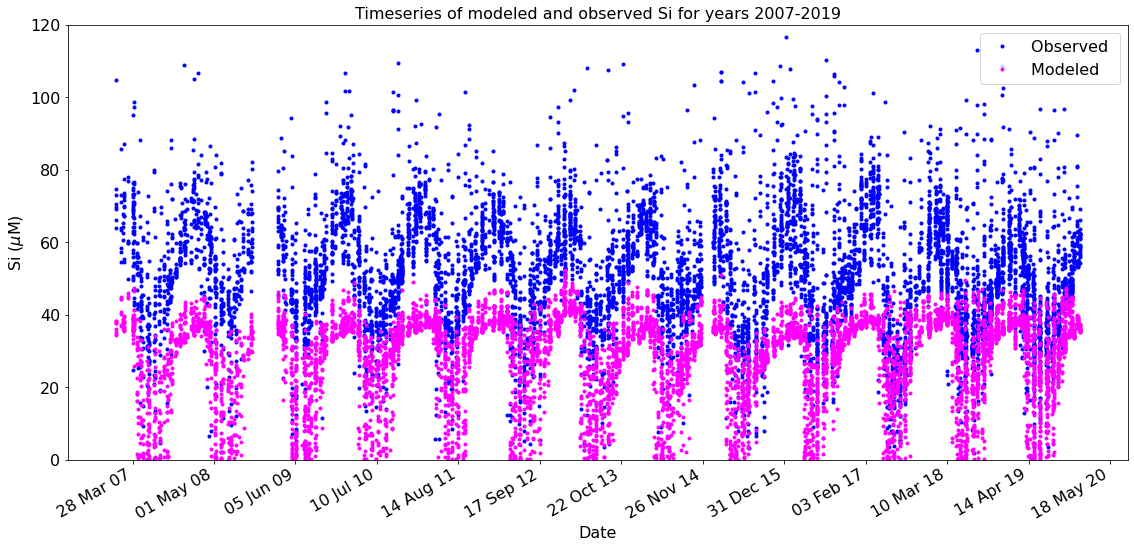

In [100]:
obsvar='Si'
modvar='mod_silicon'
all_years(obsvar,modvar)
plt.ylim(0,120)

## Ammonium

(0.0, 8.0)

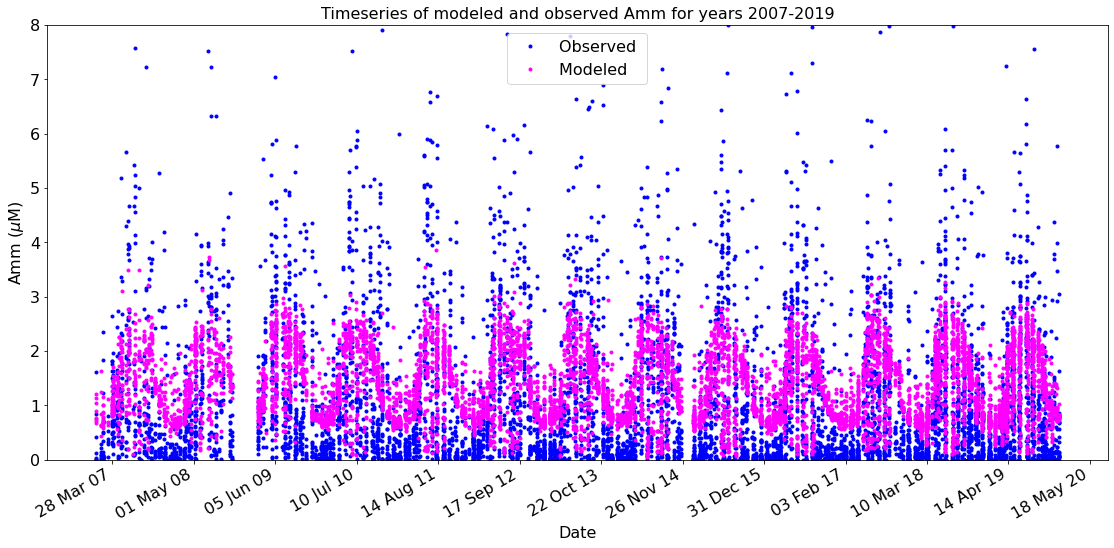

In [101]:
obsvar='Amm'
modvar='mod_ammonium'
all_years(obsvar,modvar)
plt.ylim(0,8)